<div style="text-align:center;font-size:22pt; font-weight:bold;color:white;border:solid black 1.5pt;background-color:#1e7263;">
    Understanding Model History Object: Classification Task
</div>

In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Institution: Quant Coding Versity Academy
#
# ==========================================================
# Lesson: Advanced Early Stopping Techniques
#         Medical Diagnosis Case Study
# ==========================================================
# ## Learning Objectives
# This example will enable you to:
# 1. Apply early stopping in classification tasks
# 2. Monitor multiple metrics (AUC, accuracy, loss)
# 3. Implement custom early stopping strategies
# 4. Visualize training dynamics with multiple metrics
# 5. Evaluate model performance in medical contexts
# =======================================================================
#          Copyright © Dr. Saad Laouadi 2024
# =======================================================================

In [2]:
# ==================================================== #
#        Load Required Libraries
# ==================================================== #

import os  
import shutil
from datetime import datetime

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"  


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set styling for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

# Global Config
RANDOM_STATE = 101

Author: Dr. Saad Laouadi

Last updated: 2025-01-04

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
pandas    : 2.2.2
seaborn   : 0.13.2
matplotlib: 3.9.2
keras     : 3.6.0
numpy     : 1.26.4
sklearn   : 1.5.1
tensorflow: 2.16.2



In [3]:
def cleanup_directory(directory_path):
    """
    Deletes the specified directory and all its contents.

    Args:
        directory_path (str): Path to the directory to delete.
    """
    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directory '{os.path.basename(directory_path)}' deleted successfully.")
    else:
        print(f"Directory '{os.path.basename(directory_path)}' does not exist or is not a directory.")

### ML Model Raodmap
1. Read the data
2. Explore the data

3. Processing
    - Numerical features (scaling)
    
4. Splitting the data

In [14]:
# ==================================================== #
#        Implementing Callbacks with Actual dataset
#        The Breast Cancer dataset
# ==================================================== #

def load_and_preprocess_data(random_state=0):
    """Load and preprocess the Breast Cancer dataset"""
    # Load data
    cancer = load_breast_cancer()
    X, y = cancer.data, cancer.target
    
    # Create feature names DataFrame for better understanding
    feature_df = pd.DataFrame(X, columns=cancer.feature_names)
    
    # Split data first with original labels
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=random_state, 
        stratify=y                 # stratification
    )
    
    # Then convert labels to one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, cancer.feature_names


def create_model(input_shape):
    """Create a model for breast cancer diagnosis"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        # Second layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        # Third layer
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        # Output layer for binary classification
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    # Use a custom learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']  # Track both accuracy and AUC
    )
    
    return model


def train_model_with_early_stopping():
    # Load and preprocess data
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data()
    
    # Create model
    model = create_model((X_train.shape[1],))
    
    # Create checkpoint directory
    checkpoint_dir = 'cancer_model_checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_AUC',  # Monitor AUC instead of loss
        mode='max',         # We want to maximize AUC
        patience=5,        
        min_delta=0.001,            # 0.01   
        restore_best_weights=True,
        verbose=1
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
        monitor='val_AUC',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )
    
    return model, history, X_test, y_test

def plot_training_curves(history):
    """Plot comprehensive training curves"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot AUC
    ax3.plot(history.history['AUC'], label='Training AUC')
    ax3.plot(history.history['val_AUC'], label='Validation AUC')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.legend()
    ax3.grid(True)
    
    # Plot early stopping point
    best_epoch = np.argmax(history.history['val_AUC'])
    epochs = range(1, len(history.history['loss']) + 1)
    ax4.plot(epochs, history.history['val_AUC'], 'b-', label='Validation AUC')
    ax4.axvline(x=best_epoch + 1, color='r', linestyle='--', label='Early Stopping Point')
    ax4.set_title('Early Stopping Analysis')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('AUC')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    

def evaluate_model(model, X_test, y_test, history):
    """Comprehensive model evaluation"""
    # Evaluate on test set
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
    
    # Get training statistics
    best_epoch = np.argmax(history.history['val_AUC']) + 1
    total_epochs = len(history.history['loss'])
    best_val_auc = max(history.history['val_AUC'])
    best_val_acc = max(history.history['val_accuracy'])
    
    print("\nModel Performance Summary:")
    print("-" * 50)
    print(f"Training stopped at epoch: {total_epochs}")
    print(f"Best performance at epoch: {best_epoch}")
    print(f"Best validation AUC: {best_val_auc:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print("\nTest Set Performance:")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print("-" * 50)
    
    # Calculate early stopping effectiveness
    epochs_saved = 150 - total_epochs
    print(f"\nEarly Stopping saved {epochs_saved} epochs of training!")
    print(f"Training was automatically stopped at {total_epochs}/{150} epochs")

In [15]:
# Train model
model, history, X_test, y_test = train_model_with_early_stopping()

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.7238 - accuracy: 0.6745 - loss: 0.6910
Epoch 1: val_AUC improved from -inf to 0.88238, saving model to cancer_model_checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - AUC: 0.7299 - accuracy: 0.6793 - loss: 0.6813 - val_AUC: 0.8824 - val_accuracy: 0.8242 - val_loss: 0.4795
Epoch 2/150
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.9345 - accuracy: 0.8433 - loss: 0.3481
Epoch 2: val_AUC improved from 0.88238 to 0.97718, saving model to cancer_model_checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.9367 - accuracy: 0.8457 - loss: 0.3424 - val_AUC: 0.9772 - val_accuracy: 0.9341 - val_loss: 0.3357
Epoch 3/150
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.9684 - accuracy: 0.9062 - loss: 0.2350
Epoch 3: val_AUC improved from 0.97718 to 0.99203, saving model to cancer_model_checkpoints/best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.9689 - accuracy: 0.9056 - loss:

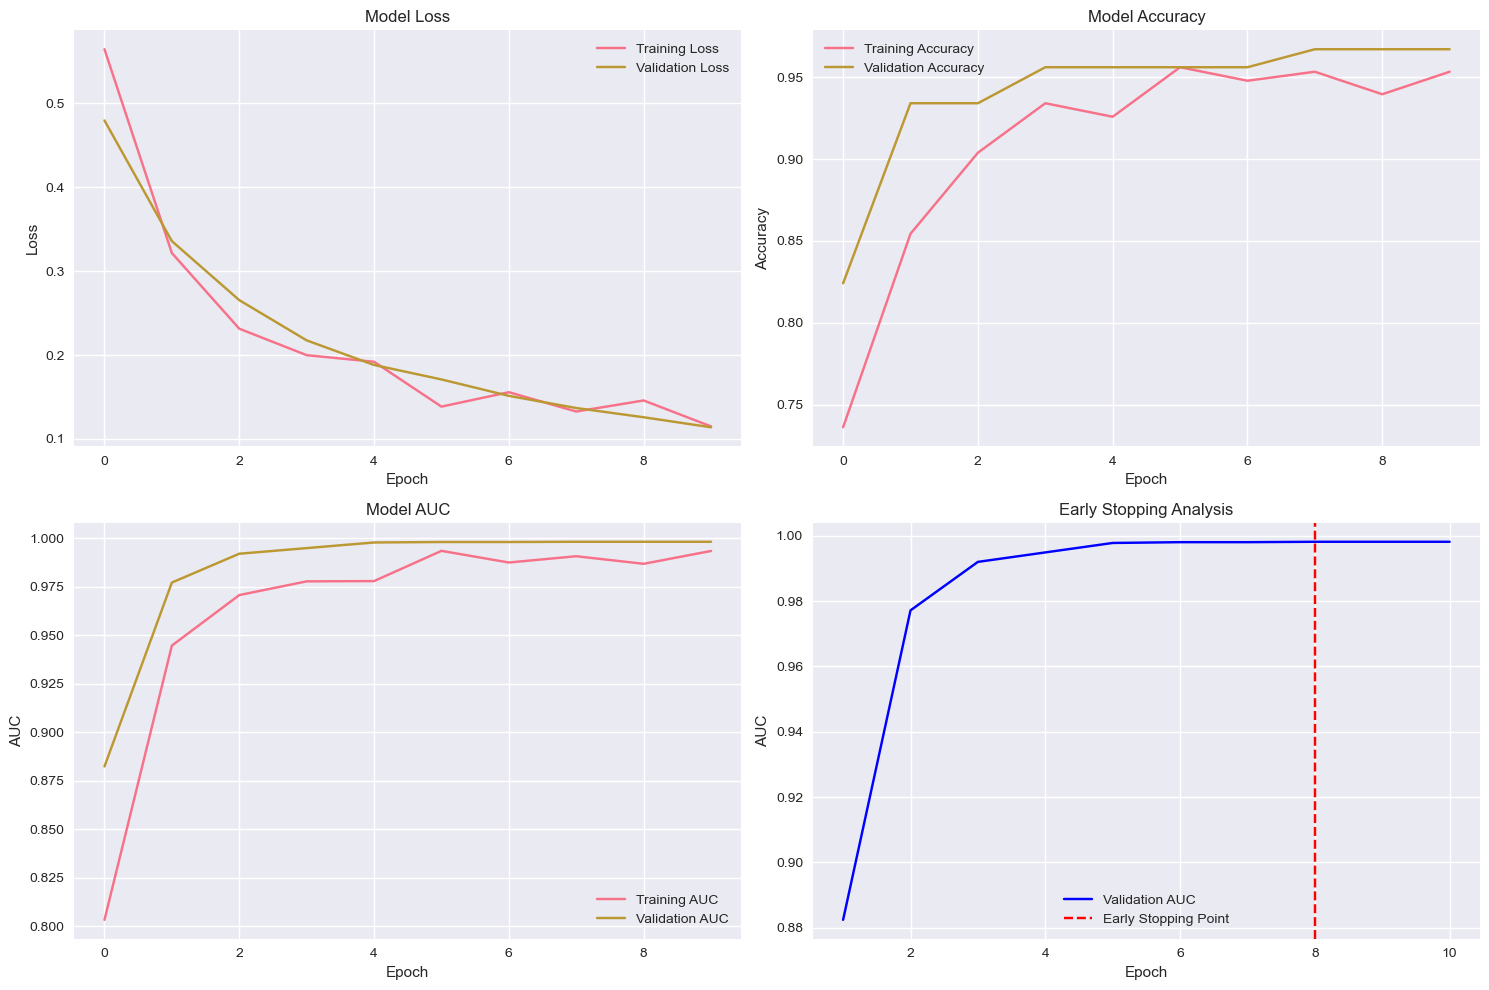

In [16]:
# Plot comprehensive results
plot_training_curves(history)

In [17]:
# Evaluate and print results
evaluate_model(model, X_test, y_test, history)


Model Performance Summary:
--------------------------------------------------
Training stopped at epoch: 10
Best performance at epoch: 8
Best validation AUC: 0.9982
Best validation accuracy: 0.9670

Test Set Performance:
Test loss: 0.2225
Test accuracy: 0.9386
Test AUC: 0.9849
--------------------------------------------------

Early Stopping saved 140 epochs of training!
Training was automatically stopped at 10/150 epochs
